In [8]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
import pandas as pd
from scipy import ndimage, stats

#device = th.device("cuda" if th.cuda.is_available() else "cpu")

if th.cuda.is_available():
    device = th.device("cuda")
    print(f"Using device {device}: {th.cuda.get_device_name()}")
elif th.backends.mps.is_available():
    device = th.device("mps")
    print(f"Using device {device}")
else:
    device = th.device("cpu")
    print(f"Using device {device}")
    

#device = th.device("cpu")
#print(f"Using device {device}")

Using device mps


In [9]:
hyperparams = {
    "learning_rate": 2e-4,
    "batch_size": 64,
    "epochs": 150,
    "l1_lambda": 100,
    "adam_betas": (0.5, 0.999), # default values are (0.9, 0.999)
}

# Dataset

## Preparing the dataset

In [10]:
#TODO: Create functions to load the dataset, perform transformations, and split into training, test, and validation sets
#TODO: Make sure that not all images are loaded into memory at once, but rather are loaded as needed to prevent crashing

def load_train_test_image_pairs(dataset_path, dataset_name):
    pass

def load_validation_images(dataset_path, dataset_name):
    pass

transforms = [
    T.Resize([256, 256], interpolation=T.InterpolationMode.NEAREST),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomCrop(256),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #TOOD: Make sure this places values in [-1,1]
]

def prep_images():
    
    training_set = th.utils.data.Dataset()
    test_set = th.utils.data.Dataset()
    validation_set = th.utils.data.Dataset()
    
    return training_set, test_set, validation_set



## Running dataset construction code

In [11]:
training_set, test_set, validation_set = prep_images()

training_set = th.utils.data.DataLoader(
    dataset=training_set,
    batch_size=hyperparams['batch_size']
    )

test_set = th.utils.data.DataLoader(
    dataset=test_set,
    batch_size=hyperparams['batch_size']
    )

validation_set = th.utils.data.DataLoader(
    dataset=validation_set,
    batch_size=hyperparams['batch_size']
    )

# Models

## Discriminator

In [12]:
class DownModule(nn.Module):
    def __init__(self, in_channels, out_channels, leaky_relu_slope=0.2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(leaky_relu_slope)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.lrelu(x)
        return x      
    
class ZeroPadModule(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        x = F.pad(x, (1, 1, 1, 1), mode='constant', value=0)
        return x

class Discriminator(nn.Module):
    
    def __init__(self, DEBUG=False):
        super().__init__()
        self.DEBUG = DEBUG
        
        self.DownLayers = nn.Sequential(
            DownModule(6, 64),
            DownModule(64, 128),
            DownModule(128, 256),
            ZeroPadModule(),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            ZeroPadModule(),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid() #NOTE: Not actually in the paper, but required for the BCELoss (limits values to [0,1]). This produces a valid probability tensor.
        )
        
    def forward(self, x: th.Tensor, y: th.Tensor) -> th.Tensor:
        """Forward pass of the discriminator

        Args:
            x (th.Tensor): Raw underwater image
            y (th.Tensor): Enhanced underwater image

        Returns:
            th.Tensor: Output tensor measuring the realness of the input images
        """
        
        z = th.concatenate((x, y), dim=1)
        
        # Input tensor shape
        if self.DEBUG:
            print("Input tensor shape:")
            print(z.shape)
        
        for layer in self.DownLayers:
            z = layer(z)
            if self.DEBUG:
                print(z.shape)
        
        return z
    
#discriminator = Discriminator(DEBUG=True).to(device)

#sample = th.rand(1, 3, 256, 256, device=device)
#clone = sample.clone()
#output = discriminator(sample, clone)

## Generator / Autoencoder

In [13]:
class EncoderModule(nn.Module):
    def __init__(self, in_channels, out_channels, leaky_relu_slope=0.2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(leaky_relu_slope)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.lrelu(x)
        return x      

class FeatureMapModule(nn.Module):
    def __init__(self, in_channels, out_channels, leaky_relu_slope=0.2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.lrelu = nn.LeakyReLU(leaky_relu_slope)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.lrelu(x)
        return x      

class DecoderModule(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.5):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.relu(x)
        return x
    
class OutputModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        
    def forward(self, x):
        x = self.deconv(x)
        return x

class Autoencoder(nn.Module):
    """
    Autoencoder model for image generation

    A residual autoencoder model for image generation. 
    The final model will be an image-to-image translation model
    that enhances underwater images.
    """
    def __init__(self, DEBUG=False):
        super().__init__()
        self.DEBUG = DEBUG

        self.EncoderLayers = nn.ModuleList([
            EncoderModule(3, 64),
            EncoderModule(64, 128),
            EncoderModule(128, 256),
            EncoderModule(256, 512),
            EncoderModule(512, 512),
            EncoderModule(512, 512),
            EncoderModule(512, 512),
            FeatureMapModule(512, 512),
        ])
        
        self.DecoderLayers = nn.ModuleList([
            DecoderModule(512, 512),
            DecoderModule(1024, 512),
            DecoderModule(1024, 512),
            DecoderModule(1024, 512, dropout_prob=0.0),
            DecoderModule(1024, 256, dropout_prob=0.0),
            DecoderModule(512, 128, dropout_prob=0.0),
            DecoderModule(256, 64, dropout_prob=0.0),
        ])
        
        self.OutputLayer = OutputModule(128, 3)
        self.sigmoid = nn.Sigmoid() #NOTE: Not actually in the paper, but required to limit values to [0,1]. This produces a valid (float) image tensor.

        
    def forward(self, x, z):
        """Forward pass for the autoencoder model.

        Args:
            x (th.Tensor): Input image tensor
            z (th.Tensor): Noise tensor

        Returns:
            th.Tensor: Output image tensor
        """

        #TODO: Figure out precisely how the noise tensor is used. Tentaively we add them together. Paper is not clear.
        x = x + z

        # Store the activations of the encoder layers for skip connections
        layer_outputs = []
        
        if self.DEBUG:
            print("Starting forward pass")
            print(x.shape)
        
        # Encoder pass
        for i in range(len(self.EncoderLayers)):
            x = self.EncoderLayers[i](x)
            if i < len(self.EncoderLayers) - 1:
                layer_outputs.append(x)
            if self.DEBUG:
                print(x.shape)
        
        if self.DEBUG:
            print("Encoding complete")
            print(x.shape)
        
        # Checking the shapes of the stored activations
        #[print("Stored activations: ",x.shape) for x in layer_outputs]
        
        # Decoder pass      
        for i in range(len(self.DecoderLayers)):
            
            if i != 0:
                # Get the appropriate encoder activation
                s = layer_outputs.pop()
                
                # If the shapes match, concatenate the activations
                if x.shape == s.shape:
                    x = th.cat((x, s), 1)
                    
                else:
                    print("Error, shapes do not match")
                    print("X:", x.shape)
                    print("S:", s.shape)
                    return th.tensor([])

            # Pass the concatenated activations through the decoder layer
            x = self.DecoderLayers[i](x)
            if self.DEBUG:
                print(x.shape)
                 
        if self.DEBUG:
            print("Decoding complete")
        
        # Perform the final deconvolution
        x = th.cat((x, layer_outputs.pop()), 1)
        x = self.OutputLayer(x)
        x = self.sigmoid(x)
        
        if self.DEBUG:
            print("Is layer_outputs empty:", len(layer_outputs) == 0)
            print(x.shape)
            print("Output complete")
            
        return x
    
#TODO: Create a noise generator that can be used to add noise to the input images using the correct generation procdure.
 
#generator = Autoencoder(DEBUG=True).to(device)

#sample = th.rand(1, 3, 256, 256, device=device)
#noise = th.rand(1, 3, 256, 256, device=device)
#output = generator(sample, noise)

# Training Loop

## Defining the loop

In [14]:
from IPython.display import clear_output

def train_loop(dataloader, discriminator, generator, d_optimizer, g_optimizer, device, epochs=150, l1_lambda=100):
    
    loss_stats = pd.DataFrame(columns=["Epoch","d_loss", "g_loss", "g_GAN_loss", "g_L1_loss"])
    
    # Define the loss functions
    d_real_loss = th.nn.BCELoss()
    d_gan_loss = th.nn.BCELoss()
    g_gan_loss = th.nn.BCELoss()
    g_l1_loss = th.nn.L1Loss()
    
    #TODO: We might need to do some pre-training individually for the discriminator and generator. Double check the paper.
            
    for epoch in range(epochs):

        for batch, (x, y) in enumerate(dataloader):
                
            x, y = x.to(device), y.to(device)
            noise = th.rand(x.shape).to(device) #TODO: Verify that the noise is generated correctly
            
            #========================#
            # Discriminator training #
            #========================#
            
            # Zero the parameter gradients
            d_optimizer.zero_grad()
            
            # Forward pass
            z = generator(x, noise).detach() 
            d_real = discriminator(x, y)
            d_fake = discriminator(x, z)
            
            # Compute the loss
            drl = d_real_loss(d_real, th.ones_like(d_real))
            dgl = d_gan_loss(d_fake, th.zeros_like(d_fake))
            
            d_loss = drl + dgl
            
            # Backward pass
            d_loss.backward()
            
            # Update weights
            d_optimizer.step() #TODO: Check if this needs to be moved to after g_loss.backward()
            
            #====================#
            # Generator training #
            #====================#
            
            # Zero the parameter gradients
            g_optimizer.zero_grad()
            
            # Forward pass
            z = generator(x, noise)
            d_fake = discriminator(x, z).detach()
            
            # Compute the loss
            ggl = g_gan_loss(d_fake, th.ones_like(d_fake))
            gl1 = g_l1_loss(z, y)
            
            g_loss = ggl + l1_lambda * gl1
            
            # Backward pass
            g_loss.backward()
            
            # Update weights
            g_optimizer.step()
            
        # Print the loss statistics
        clear_output(wait=True)
        print(f"Epoch {epoch}, batch {batch}, d_loss: {d_loss.item():.2f}, g_loss: {g_loss.item():.2f}")
            
        # Save the loss statistics
        loss_stats = pd.concat(
            [loss_stats, pd.DataFrame(
                {
                "Epoch": epoch,
                "d_loss": d_loss.item(), 
                "g_loss": g_loss.item(), 
                "g_GAN_loss": ggl.item(), 
                "g_L1_loss": gl1.item()
                }, index=[0])
                ]
            )
        
    return loss_stats

## Random noise to test loop

In [140]:
# Generate 2 batches of random images of dimensions (3, 256, 256)
size = 1000
batch1 = th.rand(size, 3, 256, 256, device=device)
batch2 = th.rand(size, 3, 256, 256, device=device)

# Create a dataloader
dataloader = th.utils.data.DataLoader(th.utils.data.TensorDataset(batch1, batch2), batch_size=hyperparams["batch_size"])

# Sample a batch from the dataloader
#sample = next(iter(dataloader))

# Display the shape of the sample
#print(sample[0].shape, sample[1].shape)

## Running the loop

Description of various GAN training problems: 
- https://developers.google.com/machine-learning/gan/problems
- https://arxiv.org/pdf/2005.00065.pdf

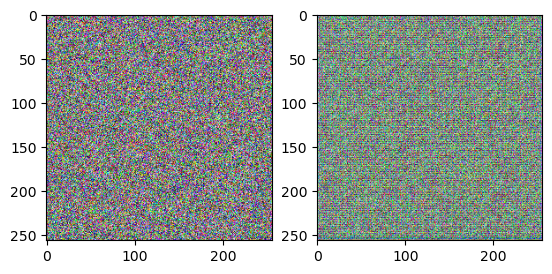

KeyboardInterrupt: 

In [16]:
train_set = dataloader

generator = Autoencoder().to(device)
discriminator = Discriminator().to(device)

# Generate a random image and noise tensor to test the generator while it is still untrained
rand_image = th.rand(1, 3, 256, 256, device=device)
rand_noise = th.rand(1, 3, 256, 256, device=device)

output = generator(rand_image, rand_noise)

# Plot the input, image pair on different subplots
fig, ax = plt.subplots(1, 2)
ax[0].imshow(rand_image.squeeze().permute(1, 2, 0).detach().cpu().numpy())
ax[1].imshow(output.squeeze().permute(1, 2, 0).detach().cpu().numpy())
plt.show()

d_optimizer = optim.Adam(
    discriminator.parameters(), 
    lr=hyperparams["learning_rate"],
    betas=hyperparams["adam_betas"],
    maximize=True,
)

g_optimizer = optim.Adam(
    generator.parameters(), 
    lr=hyperparams["learning_rate"],
    betas=hyperparams["adam_betas"],
    maximize=False,
)

loss_stats = train_loop(
    train_set, 
    discriminator, 
    generator, 
    d_optimizer, 
    g_optimizer, 
    device, 
    epochs=10,#hyperparams["epochs"], 
    l1_lambda=hyperparams["l1_lambda"]
    )

display(loss_stats)

### Plotting traing results

NameError: name 'loss_stats' is not defined

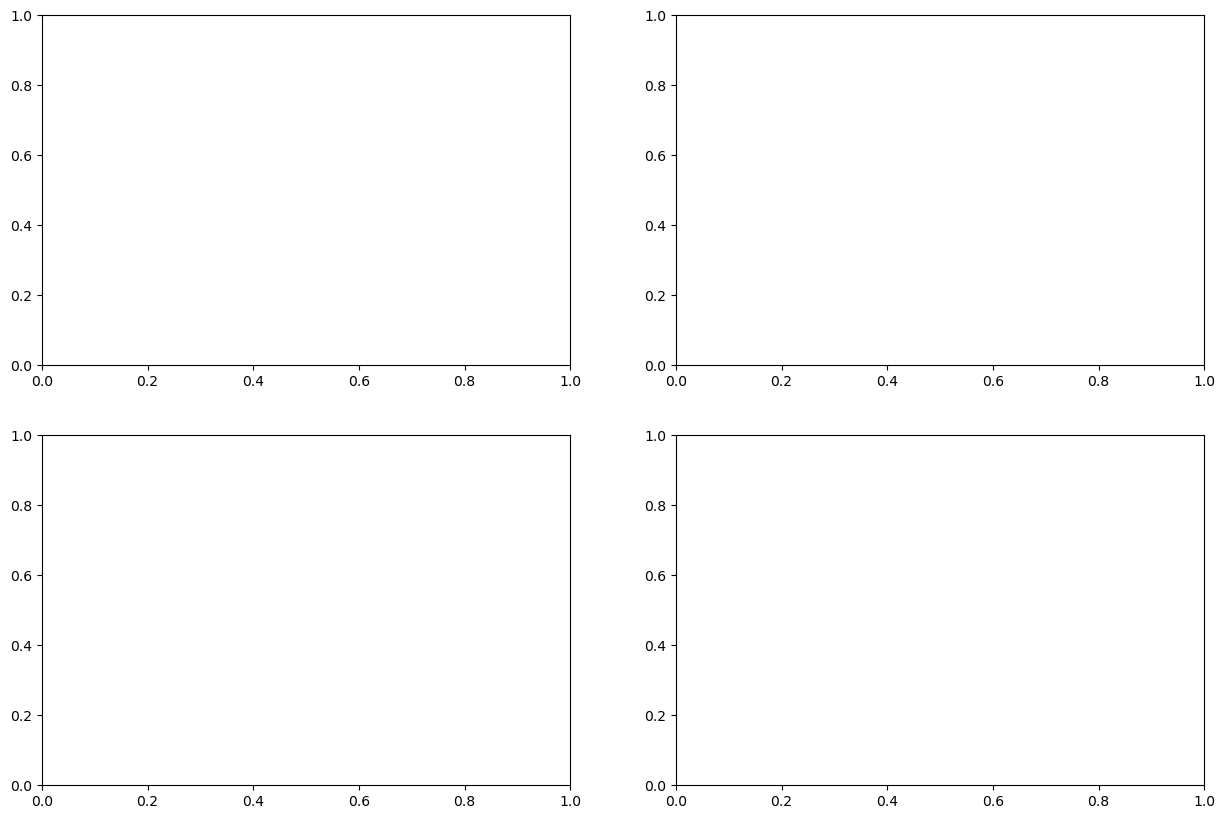

In [17]:
# Plot the loss statistics on different subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(loss_stats["Epoch"], loss_stats["d_loss"])
axs[0, 0].set_title("Discriminator loss")
axs[0, 1].plot(loss_stats["Epoch"], loss_stats["g_loss"])
axs[0, 1].set_title("Generator loss")
axs[1, 0].plot(loss_stats["Epoch"], loss_stats["g_GAN_loss"])
axs[1, 0].set_title("Generator GAN loss")
axs[1, 1].plot(loss_stats["Epoch"], loss_stats["g_L1_loss"])
axs[1, 1].set_title("Generator L1 loss")
plt.show()


### Testing image generation

tensor(1.0000, device='mps:0') tensor(1.0000, device='mps:0')
tensor(0.9991, device='mps:0', grad_fn=<MaxBackward1>)


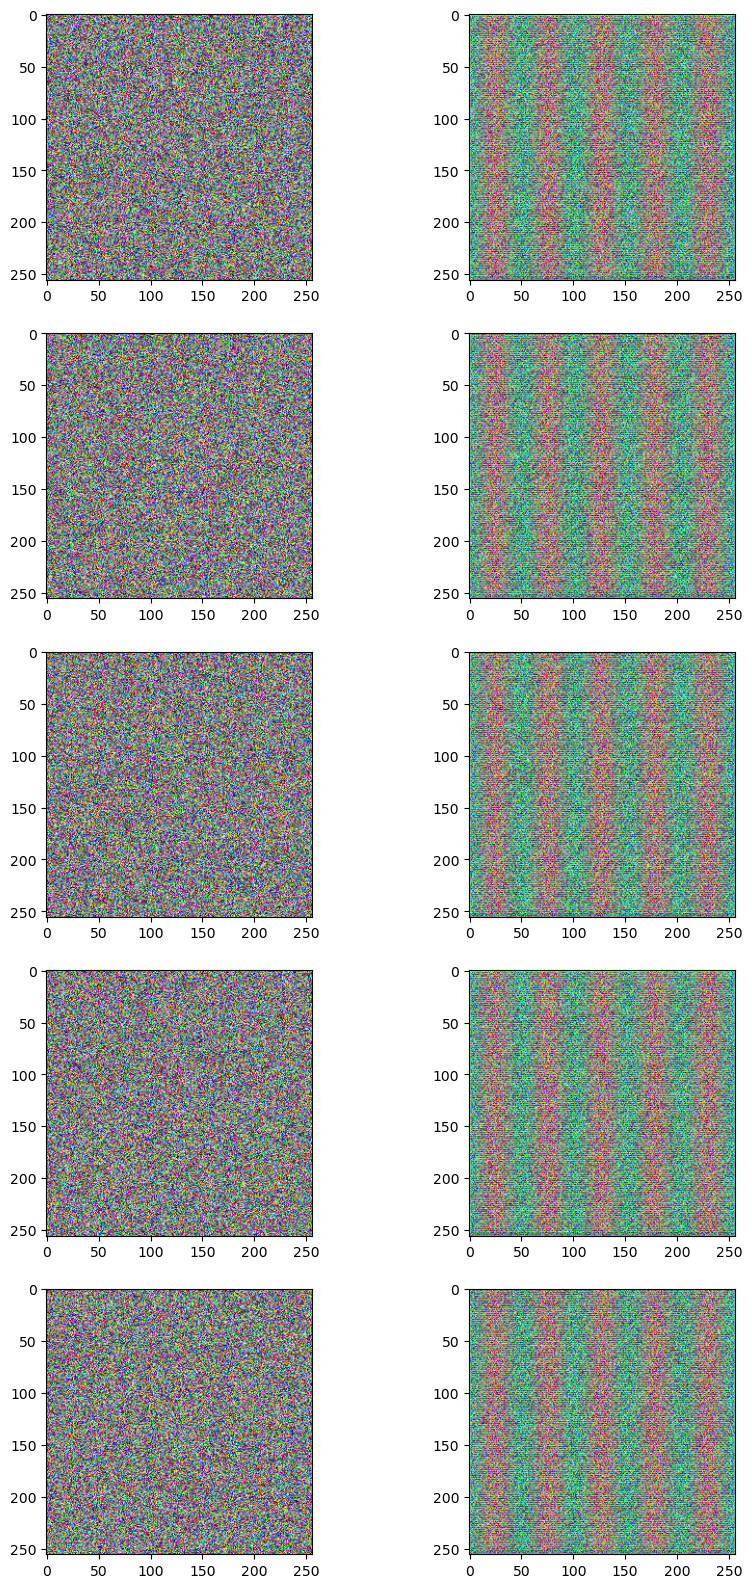

In [18]:
# Generate 10 random images using 2 noise tensors
noise1 = th.rand(10, 3, 256, 256, device=device)
noise2 = th.rand(10, 3, 256, 256, device=device)

# Print the max value of the noise tensors
print(noise1.max(), noise2.max())

# Generate 10 enhanced images
enhanced_images = generator(noise1, noise2)

# Print the max value of the enhanced images
print(enhanced_images.max())

# Plot the original and enhanced images
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    axs[i, 0].imshow(noise1[i].permute(1, 2, 0).cpu().detach().numpy())
    axs[i, 1].imshow(enhanced_images[i].permute(1, 2, 0).cpu().detach().numpy())
plt.show()

# Model evaluation

## Defining the metrics

### The UIQM rabbithole

UIQM is surprisingly complex. The following are the relevant extracts from Human-Visual-System-Inspired-Underwater_Image_Quality_Measure.pdf

#### UICM

Underwater images usually suffer from heavy noise. Therefore, instead of using the regular statistical values, the asymmetric alpha-trimmed statistical values [32] are used for measuring underwater image colorfulness in this paper. For an image with size of $M$ by $N$, the total number of pixels $K = M \cdot N$, and all pixels of the image are sorted such that $x_1 \leq x_2 \leq \dots \leq x_K$. Let $T_{\alpha L} = \lceil \alpha_L K \rceil$ (the nearest integer greater than or equal to $\alpha_L K$) and $T_{\alpha R} = \lfloor \alpha_R K \rfloor$(the nearest integer smaller than or equal to $\alpha_R K$) be the number of the smallest and greatest pixel values to be trimmed or discarded from the sorted sequence $x_1, x_2, \dots, x_K$. The asymmetric alpha-trimmed mean [32] is defined by:

$$
\mu_{\alpha,RG} = \frac{1}{K - T_{\alpha L} - T_{\alpha R}} \sum^{K-T_{\alpha R}}_{i = T_{\alpha L} + 1} {Intensity_{RG, i}}
$$

The asymmetric alpha-trimmed mean is applicable for different types of underwater images when parameters $\alpha_L$ and $\alpha_R$ change. Generally, for underwater images with lots of bubbles or light rays, such as the image in Fig. 2(a), a $\alpha_R$ greater should be used to remove the effect of the bright regions, which are not related with the natural underwater scenes, as well as some high-frequency noisy pixels, such as the salt and pepper noise. For noise-free natural scene images, such as the image in Fig. 2(b), $\alpha_L = \alpha_R = 0$ should be used. At this situation, all pixels are counted in (2) and the alpha-trimmed mean is equal to the regular mean value of the image. Similarly, the $\alpha_L$ and $\alpha_R$ portions are trimmed when calculating the high-order statistical values in (4). For the results shown in this paper,  $\alpha_L = \alpha_R = 0.1$ is used.

The first-order statistic mean value represents chrominance intensity. A mean value that is closer to zero in the $RG - YB$ opponent color component implies a better white balance. That is to say, none of the colors are dominant. It is seen from Table I that the raw underwater image in Fig. 3(a) shows a strong green color and the mean value in the $RG$ color plane $\mu_{RG}$ is -107.4312 which implies a lot of green tone, while $\mu_{RG}$ is reduced to -0.5760 in the color-corrected image in Fig. 3(b). It is seen that the enhanced image in Fig. 3(b) has a more balanced color. The second-order statistic variance $\sigma^2$ in

$$
\sigma^{2}_{\alpha, RG} = \frac{1}{N} \sum^n_{p=1}{(Intensity_{RG,p} - \mu_{\alpha, RG})^2}
$$

demonstrates the pixel activity within each color component. Intuitively, a greater variance corresponds to a higher dynamic range. Therefore, the differences in color are more distinguishable. Table I summarizes the variances of the $RG$ and $YB$ color components for the original image in Fig. 3(a) and the color-enhanced image in Fig. 3(b). It is observed that the enhanced image in Fig. 3(b) has more vivid color, which correspond to greater variance values.

The overall colorfulness metric used for measuring underwater image colorfulness is demonstrated in 

$$
UICM=-0.0268\sqrt{\mu_{\alpha,{RG}}^{2} +\mu_{\alpha,{YB}}^{2}} +\,0.1586\sqrt{\sigma_{\alpha,{RG}}^{2} +\sigma_{\alpha,{YB}}^{2}}
$$

The linear combination coefficients are obtained by linear regression. It is seen that the coefficient for the mean term is negative and the coefficient for the variance is positive, which confirm the analysis of the mathematical meaning of the two terms.

#### UISM

To measure the sharpness on edges, the Sobel edge detector is first applied on each RGB color component. The resultant edge map is then multiplied with the original image to get the grayscale edge map. By doing this, only the pixels on the edges from the original underwater image are preserved. It is known that the enhancement measure estimation (EME) measure is suitable for images with uniform background and shown nonperiodic patterns [35]. Accordingly, the EME measure is used to measure the sharpness of edges. The UISM is formulated as shown in 

$$
UISM =\sum_{c=1}^3 \lambda_{c} {\hbox {EME}}\ ({\hbox {grayscale edge}}_{c})
$$

$$
EME= {2\over k_{1} k_{2}}\sum_{l=1}^{k1} {\sum_{k=1}^{k_{2}} {\log \left({I_{\max,k,l}\over I_{\min,k,l}}\right)}}
$$

where the image is divided into k1k2 blocks, (Imax,k,l)/(Imin,k,l) indicates the relative contrast ratio within each block, and the EME measures in each RGB color component are combined linearly with coefficients $\lambda_c$, where $\lambda_R=0.299$,$\lambda_G=0.587$, and $\lambda_B=0.114$ are used according to the relative visual responses of the red, green, and blue channels [30].

The descatterring algorithm in [36] aims to remove the scattering effect of water. It is seen from Fig. 4 that the descattered underwater image in Fig. 4(b) achieves better sharpness than the original underwater image in Fig. 4(a). Accordingly, the descattered image in Fig. 4(b) has a greater UISM value. 

#### UIConM


In [143]:
def PSNR(x, y):
    """Peak Signal-to-Noise Ratio (PSNR)

    Args:
        x (np.ndarray): Image tensor, generated
        y (np.ndarray): Image tensor, ground truth

    Returns:
        float: PSNR value
    """
    # Maximum possible pixel value
    MAX = 1.0
    
    n, c, w, h = x.shape
    
    x = np.reshape(x, (n, c * w * h))
    y = np.reshape(y, (n, c * w * h))
    
    # Take the mean of the x-y difference along the batch axis
    mean = np.mean((x - y) ** 2, axis=1)
    
    # Compute the PSNR
    psnr = 10 * np.log10(MAX / mean)
    
    return psnr

def SSIM(x, y):
    """Structural Similarity Index Measure (SSIM)
    
    Args:
        x (np.ndarray): Image tensor, generated
        y (np.ndarray): Image tensor, ground truth

    Returns:
        float: SSIM value
    """
    # Maximum possible pixel value
    L = 1.0
    
    # Constants
    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2
    
    # Compute the mean of x and y along the channel, width, and height axes
    mu_x = np.mean(x, axis=(1,2,3))
    mu_y = np.mean(y, axis=(1,2,3))
    
    # Create a n, c, w, h tensor of the mean of x and y
    mu_x_b = np.broadcast_to(mu_x[:, np.newaxis, np.newaxis, np.newaxis], x.shape)
    mu_y_b = np.broadcast_to(mu_y[:, np.newaxis, np.newaxis, np.newaxis], y.shape)
    
    # Compute the variance and covariance of x and y
    sigma_x = np.mean((x - mu_x_b) ** 2, axis=(1, 2, 3))
    sigma_y = np.mean((y - mu_y_b) ** 2, axis=(1, 2, 3))
    
    sigma_xy = np.mean((x - mu_x_b) * (y - mu_y_b), axis=(1, 2, 3))
    
    # Compute the numerator and denominator of the SSIM
    num = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    den = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)

    # Take the elementwise ratio of the numerator and denominator to obtain the SSIM
    ssim = num / den

    return ssim

def UIQM(x):
    """Underwater Image Quality Measure (UIQM)
    NOTE: Works for multibatch inputs [n, 3, w, h]

    Args:
        x (np.ndarray): Image tensor

    Returns:
        float: UIQM value
    """
    
    # Constants, as per the Sea-Pix-GAN paper
    c1 = 0.0282
    c2 = 0.2953
    c3 = 3.5753
    
    # Compute the UICM, UISM, and UIConM
    uicm = UICM(x)
    uism = UISM(x)
    uiconm = UIConM(x)
    
    return c1 * uicm + c2 * uism + c3 * uiconm

def UICM(x):
    """Underwater Image Colorfulness Measure (UICM)
    NOTE: Works for multibatch inputs [n, 3, w, h]

    Args:
        x (np.ndarray): Image tensor

    Returns:
        float: UICM value
    """
    # Extract the R, G, and B channels
    R = x[:,0, :, :]
    G = x[:,1, :, :]
    B = x[:,2, :, :]
    
    # Flatten the channels for each image
    n, w, h = R.shape
    R = np.reshape(R, (n, w * h))
    G = np.reshape(G, (n, w * h))
    B = np.reshape(B, (n, w * h))
    
    # Set alpha
    alpha = 0.1
    
    # Create the RG and YB channels
    RG = R - G
    YB = 0.5 * (R + G) - B
    
    # Compute the alpha trimmed distribution along each image
    aRG = stats.trimboth(RG, alpha, axis=1)
    aYB = stats.trimboth(YB, alpha, axis=1)
    
    # Compute the mean along each image
    mean_aRG = np.mean(aRG, axis=1)
    mean_aYB = np.mean(aYB, axis=1)
        
    # Compute the alpha trimmed standard deviation along each image
    std_aRG = np.sum((RG - mean_aRG[:, np.newaxis]) ** 2, axis=1) / (w * h - 1)
    std_aYB = np.sum((YB - mean_aYB[:, np.newaxis]) ** 2, axis=1) / (w * h - 1)
    
    std_aRG = np.sqrt(std_aRG)
    std_aYB = np.sqrt(std_aYB)
        
    # Constants, as per HVSIUIQM paper
    c1 = -0.0282
    c2 = 0.1586
    
    # Compute the 2 terms of the UICM
    term_1 = np.sqrt(mean_aRG ** 2 + mean_aYB ** 2) #TODO: std can be converted to variance to save computation
    term_2 = np.sqrt(std_aRG ** 2 + std_aYB ** 2)
    
    return c1 * term_1 + c2 * term_2

def UISM(x):
    """Underwater Image Sharpness Measure (UISM)
    NOTE: Works for multibatch inputs [n, 3, w, h]

    Args:
        x (np.ndarray): Image tensor

    Returns:
        float: UISM value
    """
    #=======================#
    # Edge detection filter #
    #=======================#
    
    # Run the image through a Sobel filter, along the x and y axes respectively. 
    x_grad = ndimage.sobel(x, axis=0)
    y_grad = ndimage.sobel(x, axis=1)
    
    # Then compute the magnitude of the gradients (hypotenuse of the two gradients)
    filtered_x = np.hypot(x_grad, y_grad)
    
    #print("Filtered image shape:", filtered_x.shape)
    
    #=========================#
    # Enhancement measurement #
    #=========================#
    
    # Compute Enhancement Measure Estimation (EME) for each channel using the filtered image
    EME_R = EME(filtered_x[:,0, :, :])
    EME_G = EME(filtered_x[:,1, :, :])
    EME_B = EME(filtered_x[:,2, :, :])
    
    # Compute the weighted EME, using standard RGB channel weights
    lambda_R = 0.299
    lambda_G = 0.587
    lambda_B = 0.114
    
    return lambda_R * EME_R + lambda_G * EME_G + lambda_B * EME_B

def EME(x):
    """Enhancement Measure Estimation (EME)

    Args:
        x (np.ndarray): Image tensor, sobel filtered
        
    Returns:
        float: EME value
    """
    #TODO: What should the block size be?
    # Set the k1 and k2 constants as width and height of the image. n is the number of images in the batch
    n, k1, k2 = x.shape

    norm_const = 2 / (k1 * k2)
    
    EME = 0
    
    for i in range(k1):
        for j in range(k2):
            
            # Find max and min values in the block
            max_val = np.max(x[:, i:i+k1, j:j+k2])
            min_val = np.min(x[:, i:i+k1, j:j+k2])
            
            # Compute the local contrast
            local_contrast = np.log(max_val / min_val)
            
            EME += local_contrast
            
    return norm_const * EME

def UIConM(x):
    """Underwater Image Contrast Measure (UIConM)
    NOTE: Works for multibatch inputs [n, 3, w, h]

    Args:
        x (np.ndarray): Image tensor

    Returns:
        float: UIConM value
    """
    # RGB channel weights
    lambda_R = 0.299
    lambda_G = 0.587
    lambda_B = 0.114
    
    # Exract the intensity of the image, using standard RGB channel weights
    I = lambda_R * x[:,0, :, :] + lambda_G * x[:,1, :, :] + lambda_B * x[:,2, :, :]
    
    print("I shape:", I.shape)
    
    # Compute the logAMEE(Intensity)
    logamee = logAMEE(I)
    
    return logamee

def logAMEE(x):
    """Logarithmic Agaian Measure of Enhancement by Engropy (logAMEE)

    Args:
        x (np.ndarray): Image tensor, weighted intensity

    Returns:
        float: logAMEE value
    """
    # Define the PLIP operators
    add = lambda x,y: x + y - x * y         # circle-plus operator
    mul = lambda x,y: x * y                 # circle-multiply operator
    diff = lambda x,y: (x - y) / (1 - y)    # Theta operator
    
    # Define k1 and k2 as the width and height of the image
    n, k1, k2 = x.shape
    
    # Define the constants
    norm_const = 1 / (k1 * k2)
    
    logamee = 0
    
    for i in range(k1):
        for j in range(k2):
            
            # Extract the block
            block = x[:, i:i+k1, j:j+k2]
            
            # Find the maximum and minimum values in the block
            max_val = np.max(block)
            min_val = np.min(block)
            
            I_diff = diff(max_val, min_val)
            I_add = add(max_val, min_val)
            
            ratio = I_diff / I_add
            
            logamee += ratio * np.log(ratio)
            
    return norm_const * logamee
    
def get_metrics(test_data, generator):
    metrics = pd.DataFrame(columns=["PSNR", "SSIM", "UIQM"])
    
    # Sample 500 images from the test set and compute the metrics on them
    x, y = next(iter(test_data))
    
    print(x.shape)
    print(y.shape)
    
    x = x.to(device)
    y = y.detach().cpu().numpy()
    
    noise = th.rand(x.shape, dtype=th.float32).to(device)
    
    enhanced = generator(x, noise).detach().cpu().numpy()
    
    psnr = PSNR(y, enhanced)
    ssim = SSIM(y, enhanced)
    uiqm = UIQM(enhanced)
    
    batch_metrics = pd.DataFrame(
        {
        "PSNR": psnr, 
        "SSIM": ssim, 
        "UIQM": uiqm
        }
        )
    
    metrics = pd.concat(
        [metrics, batch_metrics]
        )
        
    return metrics

## Getting the test metrics

In [144]:
#TODO: Replace the random noise with the actual test data
test_data = th.utils.data.DataLoader(th.utils.data.TensorDataset(batch1, batch2), batch_size=500)

raw_metrics = get_metrics(test_data, generator)

summary = pd.DataFrame(columns=["Mean", "Std"])

summary.loc["PSNR"] = [raw_metrics["PSNR"].mean(), raw_metrics["PSNR"].std()]
summary.loc["SSIM"] = [raw_metrics["SSIM"].mean(), raw_metrics["SSIM"].std()]
summary.loc["UIQM"] = [raw_metrics["UIQM"].mean(), raw_metrics["UIQM"].std()]

display(raw_metrics.head())

display(summary)

torch.Size([500, 3, 256, 256])
torch.Size([500, 3, 256, 256])


RuntimeError: MPS backend out of memory (MPS allocated: 7.76 GB, other allocations: 2.32 GB, max allowed: 9.07 GB). Tried to allocate 256 bytes on shared pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

# Saving the model

In [ ]:
# Path to the model weights
path = "./rsc/model_weights/"
discriminator_path = path + "discriminator.pth"
generator_path = path + "generator.pth"

# Save model weights for discriminator and generator
th.save(discriminator.state_dict(), discriminator_path)
th.save(generator.state_dict(), generator_path)